1. Exportación de una imagen NDVI promedio mensual obtenida con el satellite MODIS. La imagen será exportada al Drive en la carpeta GEE_Exports

In [11]:
import ee

# Inicializar Earth Engine
ee.Initialize(project='agtech-suscripci-1759332935027')

# Definir área de interés - Turipaná
turipana = ee.Geometry.Rectangle([-75.89, 8.88, -75.86, 8.91])

# Definir periodo de tiempo
start_date = '2023-01-01'
end_date = '2023-12-31'

# Cargar colección MODIS NDVI
modis = ee.ImageCollection('MODIS/006/MOD13Q1').filterDate(start_date, end_date).filterBounds(turipana).select('NDVI')

# Calcular NDVI promedio mensual
ndvi_mean = modis.mean().multiply(0.0001)

# Configurar la exportación a Google Drive
task = ee.batch.Export.image.toDrive(
    image=ndvi_mean,
    description='NDVI_MODIS_Turipana_2023',
    folder='GEE_Exports',
    region=turipana,
    scale=250,
    crs='EPSG:4326',
    maxPixels=1e9
)

# Iniciar la tarea de exportación
task.start()

print('Tarea de exportación iniciada')
print(f'ID de la tarea: {task.id}')
print('Revisa tu Google Drive en la carpeta GEE_Exports')

Tarea de exportación iniciada
ID de la tarea: VW2U5VTBQYJDR2FFKYW43KFL
Revisa tu Google Drive en la carpeta GEE_Exports


In [12]:
import ee
import geemap

# Inicializar Earth Engine
ee.Initialize(project='agtech-suscripci-1759332935027')

# Definir área de interés - Turipaná
turipana = ee.Geometry.Rectangle([-75.89, 8.88, -75.86, 8.91])

# Definir periodo de tiempo
start_date = '2023-01-01'
end_date = '2023-12-31'

# Cargar colección MODIS NDVI
modis = ee.ImageCollection('MODIS/006/MOD13Q1').filterDate(start_date, end_date).filterBounds(turipana).select('NDVI')

# Calcular NDVI promedio
ndvi_mean = modis.mean().multiply(0.0001)

# Recortar la imagen NDVI solo al área de Turipaná
ndvi_turipana = ndvi_mean.clip(turipana)

# Crear mapa con estilo street view
Map = geemap.Map(ee_initialize=False, basemap='HYBRID')
Map.centerObject(turipana, 14)

# Parámetros de visualización para NDVI
ndvi_vis = {
    'min': 0,
    'max': 1,
    'palette': ['red', 'yellow', 'green']
}

# Agregar solo la capa NDVI recortada a Turipaná
Map.addLayer(ndvi_turipana, ndvi_vis, 'NDVI MODIS 2023 - Turipaná')
Map.addLayer(turipana, {'color': 'blue'}, 'Límite Turipaná', opacity=0.5)

# Mostrar mapa
Map

Map(center=[8.89500009511003, -75.87500000000182], controls=(WidgetControl(options=['position', 'transparent_b…

Comparación Temporal NDVI: MODIS vs Sentinel-2

Extrayendo datos de MODIS (cada 16 días, nubes < 50%)...
Total de imágenes MODIS: 3
  MODIS 2022-12-31: NDVI = 0.635
  MODIS 2023-01-16: NDVI = 0.614
  MODIS 2023-02-01: NDVI = 0.546

Total puntos MODIS: 3

Extrayendo datos de Sentinel-2 (mensual, nubes < 10%)...
  Sentinel-2 Mes 2: NDVI = 0.447 (3 imágenes)

Total puntos Sentinel-2: 1


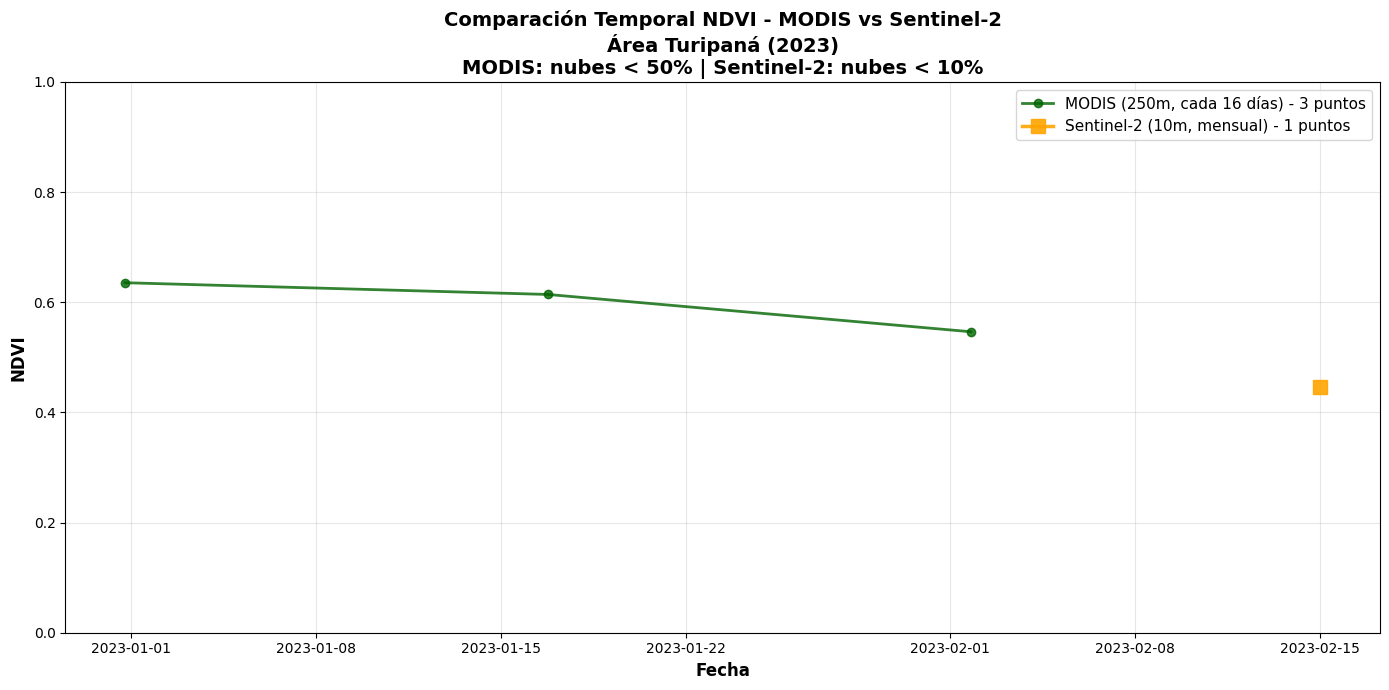


Estadísticas MODIS:
  Número de observaciones: 3
  Promedio: 0.599
  Min: 0.546
  Max: 0.635
  Desviación estándar: 0.047

Estadísticas Sentinel-2:
  Número de observaciones: 1
  Promedio: 0.447
  Min: 0.447
  Max: 0.447
  Desviación estándar: nan

Relación de puntos MODIS/Sentinel-2: 3.0:1


In [13]:
%matplotlib inline

import ee
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Inicializar Earth Engine
ee.Initialize(project='agtech-suscripci-1759332935027')

print("Comparación Temporal NDVI: MODIS vs Sentinel-2")
print("="*60)

# Definir área de interés - Turipaná
turipana = ee.Geometry.Rectangle([-75.89, 8.88, -75.86, 8.91])

# Definir periodo
start_date = '2023-01-01'
end_date = '2023-12-31'

# Función para extraer NDVI cada 16 días de MODIS (filtro de calidad más permisivo)
def get_modis_ndvi():
    # MOD13Q1 tiene composiciones cada 16 días
    # Usamos un filtro de calidad menos estricto para tener más puntos
    modis = ee.ImageCollection('MODIS/006/MOD13Q1').filterDate(start_date, end_date).filterBounds(turipana).select(['NDVI', 'DetailedQA'])
    
    results = []
    modis_list = modis.toList(modis.size())
    count = modis.size().getInfo()
    
    print(f"Total de imágenes MODIS: {count}")
    
    for i in range(count):
        image = ee.Image(modis_list.get(i))
        
        # Obtener fecha
        date = ee.Date(image.get('system:time_start'))
        date_info = date.getInfo()
        date_obj = datetime.fromtimestamp(date_info['value'] / 1000)
        
        # Filtro de calidad más permisivo (acepta calidad buena y marginal)
        qa = image.select('DetailedQA')
        # Bits 0-1: 00 = good, 01 = marginal (aceptamos ambos para más datos)
        quality_mask = qa.bitwiseAnd(3).lte(1)
        
        ndvi = image.select('NDVI').updateMask(quality_mask).multiply(0.0001)
        
        stats = ndvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=turipana,
            scale=250,
            maxPixels=1e9
        ).getInfo()
        
        ndvi_value = stats.get('NDVI')
        if ndvi_value is not None:
            results.append({
                'date': date_obj,
                'ndvi': ndvi_value,
                'day_of_year': date_obj.timetuple().tm_yday
            })
            print(f"  MODIS {date_obj.strftime('%Y-%m-%d')}: NDVI = {ndvi_value:.3f}")
    
    return results

# Función para extraer NDVI mensual de Sentinel-2 (filtro de nubes más estricto)
def get_sentinel_monthly_ndvi():
    results = []
    for month in range(1, 13):
        month_start = ee.Date.fromYMD(2023, month, 1)
        month_end = month_start.advance(1, 'month')
        
        # Filtro más estricto: solo imágenes con menos de 10% de nubes
        s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(month_start, month_end).filterBounds(turipana).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)).select(['B4', 'B8'])
        
        count = s2.size().getInfo()
        
        if count > 0:
            def add_ndvi(image):
                ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
                return image.addBands(ndvi)
            
            s2_ndvi = s2.map(add_ndvi).select('NDVI')
            ndvi_mean = s2_ndvi.median()
            
            stats = ndvi_mean.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=turipana,
                scale=10,
                maxPixels=1e9
            ).getInfo()
            
            ndvi_value = stats.get('NDVI')
            if ndvi_value is not None:
                date_obj = datetime(2023, month, 15)
                results.append({
                    'date': date_obj,
                    'ndvi': ndvi_value,
                    'month': month
                })
                print(f"  Sentinel-2 Mes {month}: NDVI = {ndvi_value:.3f} ({count} imágenes)")
    
    return results

# Extraer datos
print("\nExtrayendo datos de MODIS (cada 16 días, nubes < 50%)...")
modis_data = get_modis_ndvi()
print(f"\nTotal puntos MODIS: {len(modis_data)}")

print("\nExtrayendo datos de Sentinel-2 (mensual, nubes < 10%)...")
sentinel_data = get_sentinel_monthly_ndvi()
print(f"\nTotal puntos Sentinel-2: {len(sentinel_data)}")

# Crear DataFrames
df_modis = pd.DataFrame(modis_data)
df_sentinel = pd.DataFrame(sentinel_data)

# Visualización
fig, ax = plt.subplots(figsize=(14, 7))

# Plotear MODIS con más puntos
ax.plot(df_modis['date'], df_modis['ndvi'], marker='o', linewidth=2, markersize=6, label=f'MODIS (250m, cada 16 días) - {len(df_modis)} puntos', color='darkgreen', alpha=0.8)

# Plotear Sentinel-2 mensual
ax.plot(df_sentinel['date'], df_sentinel['ndvi'], marker='s', linewidth=2.5, markersize=10, label=f'Sentinel-2 (10m, mensual) - {len(df_sentinel)} puntos', color='orange', alpha=0.9)

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('NDVI', fontsize=12, fontweight='bold')
ax.set_title('Comparación Temporal NDVI - MODIS vs Sentinel-2\nÁrea Turipaná (2023)\nMODIS: nubes < 50% | Sentinel-2: nubes < 10%', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=11)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Estadísticas
print("\n" + "="*60)
print("Estadísticas MODIS:")
print(f"  Número de observaciones: {len(df_modis)}")
print(f"  Promedio: {df_modis['ndvi'].mean():.3f}")
print(f"  Min: {df_modis['ndvi'].min():.3f}")
print(f"  Max: {df_modis['ndvi'].max():.3f}")
print(f"  Desviación estándar: {df_modis['ndvi'].std():.3f}")

print("\nEstadísticas Sentinel-2:")
print(f"  Número de observaciones: {len(df_sentinel)}")
print(f"  Promedio: {df_sentinel['ndvi'].mean():.3f}")
print(f"  Min: {df_sentinel['ndvi'].min():.3f}")
print(f"  Max: {df_sentinel['ndvi'].max():.3f}")
print(f"  Desviación estándar: {df_sentinel['ndvi'].std():.3f}")

print("\nRelación de puntos MODIS/Sentinel-2: {:.1f}:1".format(len(df_modis)/len(df_sentinel) if len(df_sentinel) > 0 else 0))

Análisis de Firmas Espectrales

Extrayendo firmas espectrales MODIS (año 2023)...
  Vegetación: 6 imágenes MODIS disponibles
  Vegetación: [0.09025000000000001, 0.3179, 0.0468, 0.09115000000000001, 0.3633, 0.30115000000000003, 0.1534]
  Suelo: 6 imágenes MODIS disponibles
  Suelo: [0.07974677419354839, 0.3222983870967742, 0.041456451612903227, 0.08009354838709679, 0.37863225806451617, 0.31415161290322585, 0.16131290322580644]
  Agua: 6 imágenes MODIS disponibles
  Agua: [0.0785, 0.3325, 0.040100000000000004, 0.081, 0.3801, 0.30465000000000003, 0.15535000000000002]

Extrayendo firmas espectrales Sentinel-2 (año 2023)...
  Vegetación: 12 imágenes Sentinel-2 disponibles
  Vegetación: [0.054427116290077494, 0.0752244569143768, 0.08633183839465884, 0.23279272190528405, 0.33022769113873607, 0.20149572818315437]
  Suelo: 12 imágenes Sentinel-2 disponibles
  Suelo: [0.0619921190980441, 0.084487083592874, 0.09602235455338232, 0.2556792830447239, 0.35335469976329875, 0.22158226734770142]
  Agua:

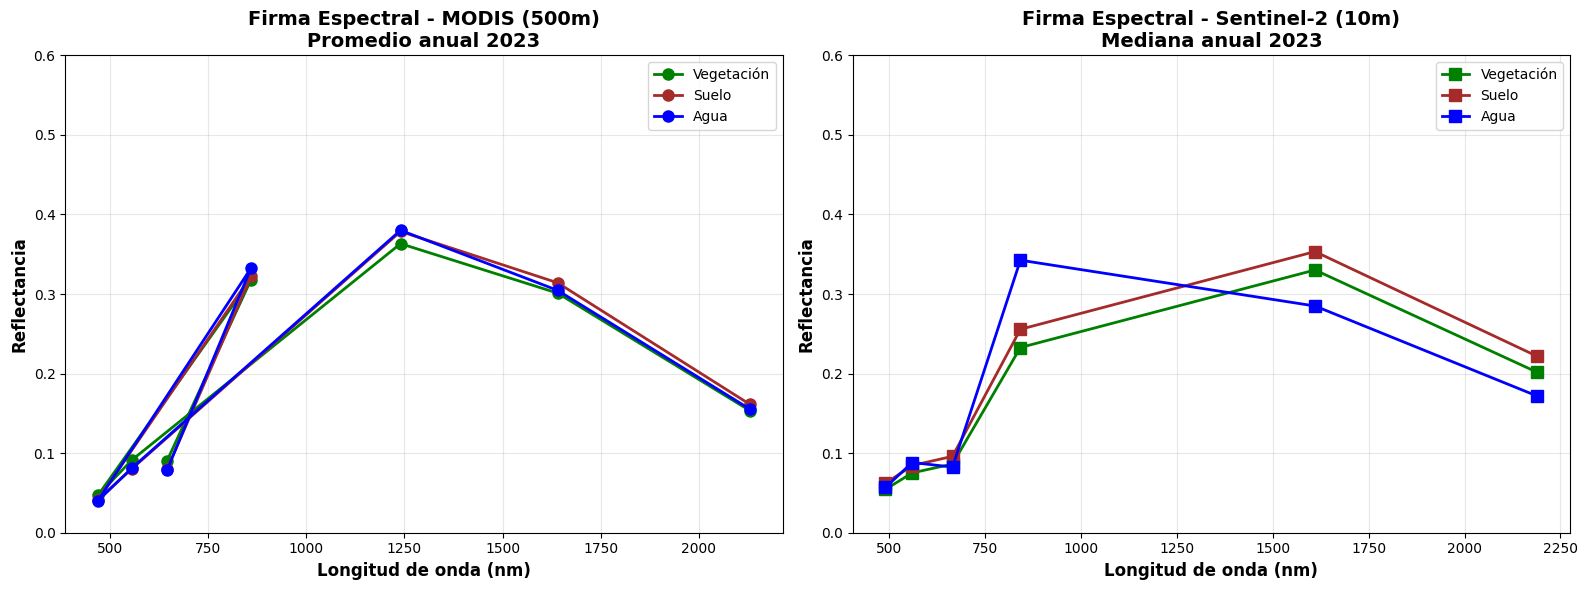


Análisis completado
Firmas MODIS extraídas: 3
Firmas Sentinel-2 extraídas: 3


In [14]:
%matplotlib inline

import ee
import matplotlib.pyplot as plt
import numpy as np

# Inicializar Earth Engine
ee.Initialize(project='agtech-suscripci-1759332935027')

print("Análisis de Firmas Espectrales")
print("="*60)

# Definir área de interés - Turipaná
turipana = ee.Geometry.Rectangle([-75.89, 8.88, -75.86, 8.91])

# Definir puntos para diferentes tipos de cobertura
punto_vegetacion = ee.Geometry.Point([-75.875, 8.895])
punto_suelo = ee.Geometry.Point([-75.880, 8.890])
punto_agua = ee.Geometry.Point([-75.870, 8.885])

puntos = {
    'Vegetación': punto_vegetacion,
    'Suelo': punto_suelo,
    'Agua': punto_agua
}

colores = {
    'Vegetación': 'green',
    'Suelo': 'brown',
    'Agua': 'blue'
}

# Periodo de análisis más amplio (todo el año 2023)
date = '2023-01-01'
date_end = '2023-12-31'

# MODIS - Bandas espectrales
modis_bands = ['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']
modis_wavelengths = [645, 859, 469, 555, 1240, 1640, 2130]  # Longitudes de onda en nm

# Sentinel-2 - Bandas espectrales
s2_bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
s2_wavelengths = [490, 560, 665, 842, 1610, 2190]  # Longitudes de onda en nm

# Extraer firma espectral MODIS
def get_modis_signature(point, label):
    try:
        modis_col = ee.ImageCollection('MODIS/006/MOD09A1').filterDate(date, date_end).filterBounds(point).select(modis_bands)
        
        count = modis_col.size().getInfo()
        print(f"  {label}: {count} imágenes MODIS disponibles")
        
        if count == 0:
            print(f"  Advertencia: No hay imágenes MODIS para {label}")
            return None
        
        # Usar mediana para obtener valores representativos
        modis = modis_col.median()
        
        values = modis.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point.buffer(100),
            scale=500,
            maxPixels=1e9
        ).getInfo()
        
        signature = [values.get(band, 0) * 0.0001 for band in modis_bands]
        
        # Verificar si hay valores válidos
        if all(v == 0 for v in signature):
            print(f"  Advertencia: Todos los valores son 0 para {label}")
            return None
            
        return signature
    except Exception as e:
        print(f"  Error extrayendo MODIS para {label}: {str(e)}")
        return None

# Extraer firma espectral Sentinel-2
def get_sentinel_signature(point, label):
    try:
        s2_col = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(date, date_end).filterBounds(point).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).select(s2_bands)
        
        count = s2_col.size().getInfo()
        print(f"  {label}: {count} imágenes Sentinel-2 disponibles")
        
        if count == 0:
            print(f"  Advertencia: No hay imágenes Sentinel-2 para {label}")
            return None
        
        # Usar mediana para obtener valores representativos
        s2 = s2_col.median()
        
        values = s2.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point.buffer(100),
            scale=10,
            maxPixels=1e9
        ).getInfo()
        
        signature = [values.get(band, 0) / 10000.0 for band in s2_bands]
        
        # Verificar si hay valores válidos
        if all(v == 0 for v in signature):
            print(f"  Advertencia: Todos los valores son 0 para {label}")
            return None
            
        return signature
    except Exception as e:
        print(f"  Error extrayendo Sentinel-2 para {label}: {str(e)}")
        return None

# Crear subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: MODIS
print("\nExtrayendo firmas espectrales MODIS (año 2023)...")
modis_signatures = {}
for label, punto in puntos.items():
    signature = get_modis_signature(punto, label)
    if signature is not None:
        modis_signatures[label] = signature
        ax1.plot(modis_wavelengths, signature, marker='o', linewidth=2, markersize=8, label=label, color=colores[label])
        print(f"  {label}: {signature}")

if modis_signatures:
    ax1.set_xlabel('Longitud de onda (nm)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Reflectancia', fontsize=12, fontweight='bold')
    ax1.set_title('Firma Espectral - MODIS (500m)\nPromedio anual 2023', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best', fontsize=10)
    ax1.set_ylim(0, 0.6)
else:
    ax1.text(0.5, 0.5, 'No hay datos MODIS disponibles', ha='center', va='center', transform=ax1.transAxes)

# Gráfico 2: Sentinel-2
print("\nExtrayendo firmas espectrales Sentinel-2 (año 2023)...")
s2_signatures = {}
for label, punto in puntos.items():
    signature = get_sentinel_signature(punto, label)
    if signature is not None:
        s2_signatures[label] = signature
        ax2.plot(s2_wavelengths, signature, marker='s', linewidth=2, markersize=8, label=label, color=colores[label])
        print(f"  {label}: {signature}")

if s2_signatures:
    ax2.set_xlabel('Longitud de onda (nm)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Reflectancia', fontsize=12, fontweight='bold')
    ax2.set_title('Firma Espectral - Sentinel-2 (10m)\nMediana anual 2023', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best', fontsize=10)
    ax2.set_ylim(0, 0.6)
else:
    ax2.text(0.5, 0.5, 'No hay datos Sentinel-2 disponibles', ha='center', va='center', transform=ax2.transAxes)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Análisis completado")
print(f"Firmas MODIS extraídas: {len(modis_signatures)}")
print(f"Firmas Sentinel-2 extraídas: {len(s2_signatures)}")

5- Análisis Temporal de NDVI por Píxeles
Este código selecciona grupos de píxeles en diferentes zonas del área de interés y grafica la evolución temporal del NDVI mensual

📊 Análisis Temporal de NDVI por Píxeles
Regiones definidas: 4

Creando mapa interactivo con las 4 zonas...
Mapa guardado como 'index.html'


Map(center=[8.89500009511003, -75.87500000000182], controls=(WidgetControl(options=['position', 'transparent_b…


Extrayendo datos temporales...
  Procesando Zona Norte...
    2022-01: NDVI = 0.733
    2022-02: NDVI = 0.492
    2022-12: NDVI = 0.739
    2023-01: NDVI = 0.507
    2023-02: NDVI = 0.398
    2023-07: NDVI = 0.769
  Procesando Zona Sur...
    2022-01: NDVI = 0.746
    2022-02: NDVI = 0.555
    2022-12: NDVI = 0.808
    2023-01: NDVI = 0.583
    2023-02: NDVI = 0.516
    2023-07: NDVI = 0.827
  Procesando Zona Este...
    2022-01: NDVI = 0.647
    2022-02: NDVI = 0.495
    2022-12: NDVI = 0.759
    2023-01: NDVI = 0.559
    2023-02: NDVI = 0.470
    2023-07: NDVI = 0.830
  Procesando Zona Oeste...
    2022-01: NDVI = 0.658
    2022-02: NDVI = 0.567
    2022-12: NDVI = 0.665
    2023-01: NDVI = 0.567
    2023-02: NDVI = 0.550
    2023-07: NDVI = 0.628
Extracción completada
Datos procesados: 24 registros válidos


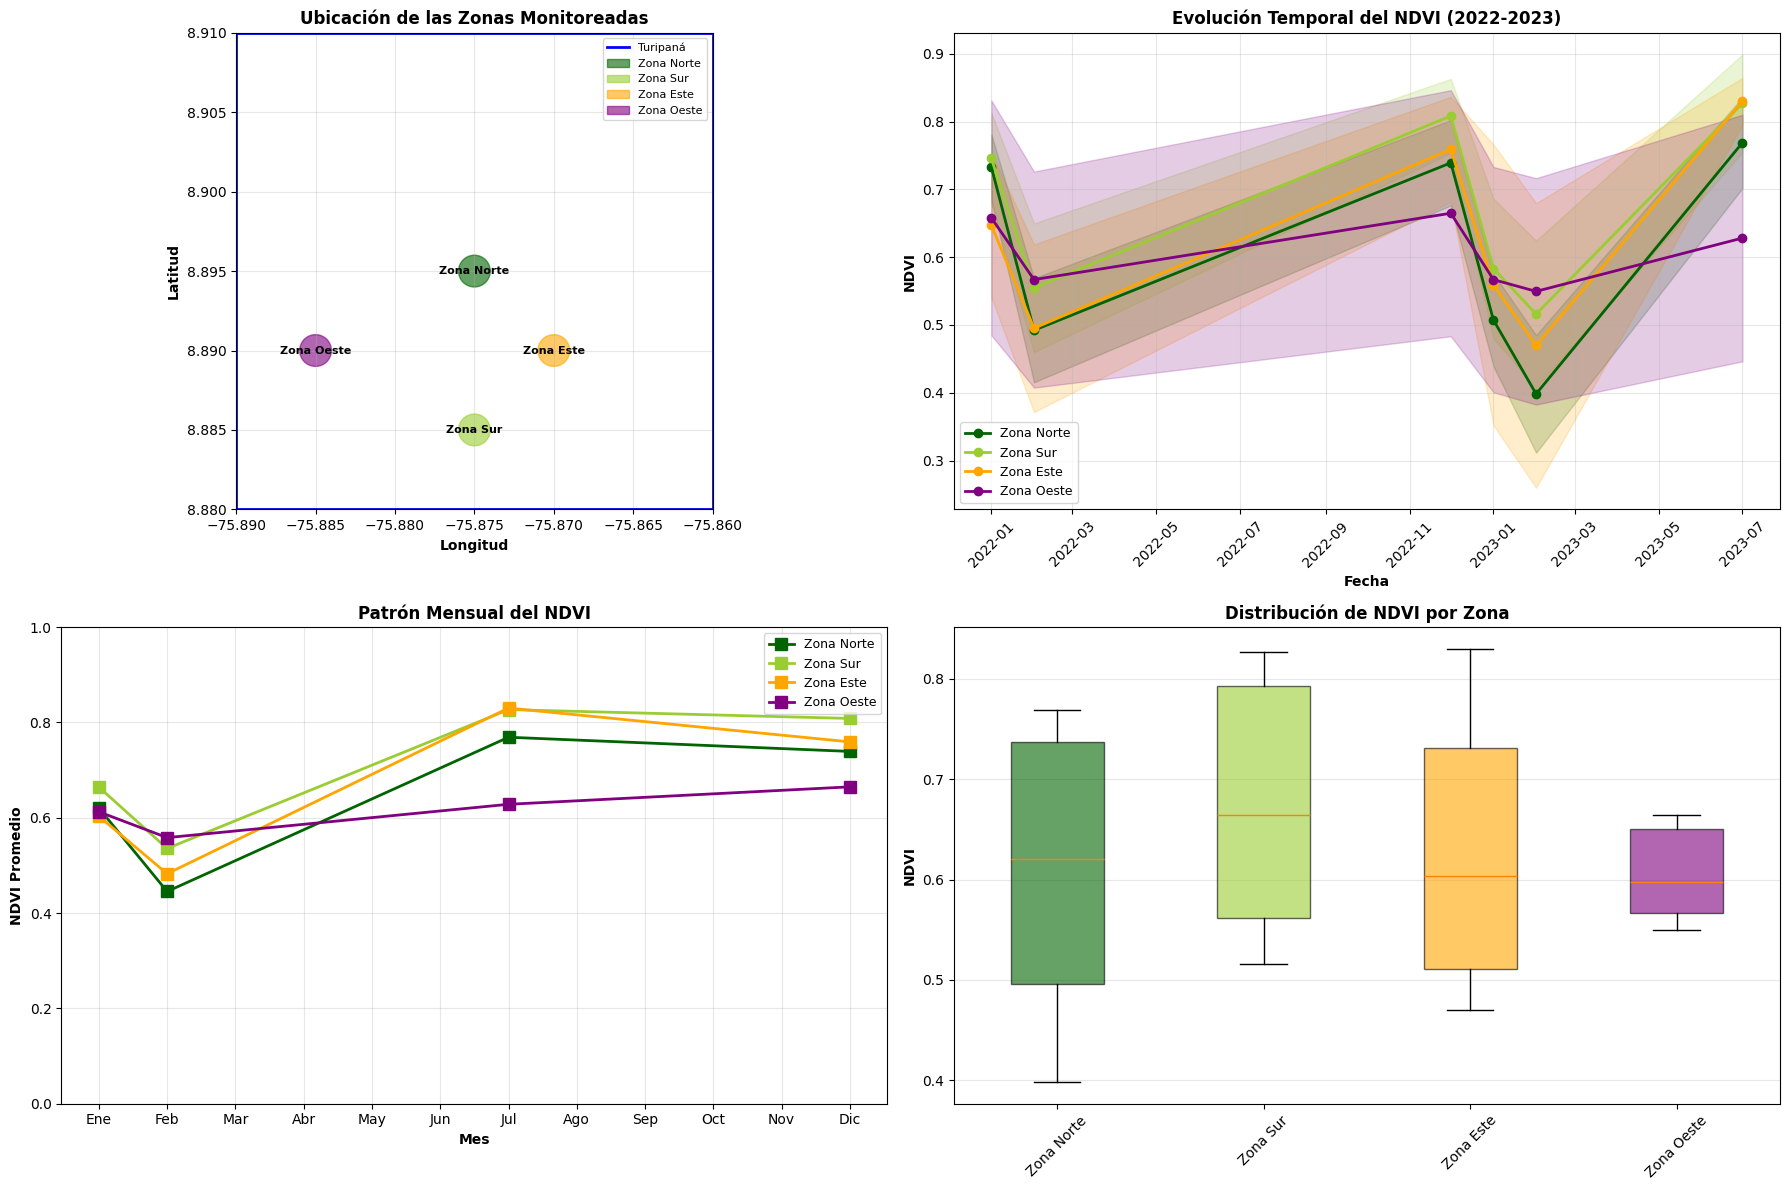


Estadísticas por Región:

Zona Norte:
  Promedio: 0.606
  Min: 0.398
  Max: 0.769
  Desv. Est.: 0.159
  Observaciones: 6

Zona Sur:
  Promedio: 0.672
  Min: 0.516
  Max: 0.827
  Desv. Est.: 0.137
  Observaciones: 6

Zona Este:
  Promedio: 0.627
  Min: 0.470
  Max: 0.830
  Desv. Est.: 0.145
  Observaciones: 6

Zona Oeste:
  Promedio: 0.606
  Min: 0.550
  Max: 0.665
  Desv. Est.: 0.051
  Observaciones: 6

Analisis completado
Mapa interactivo disponible en 'index.html'


In [15]:
%matplotlib inline

import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Inicializar Earth Engine
ee.Initialize(project='agtech-suscripci-1759332935027')

print("📊 Análisis Temporal de NDVI por Píxeles")
print("="*60)

# Definir área de interés - Turipaná
turipana = ee.Geometry.Rectangle([-75.89, 8.88, -75.86, 8.91])

# Definir 4 regiones (grupos de píxeles)
region1 = ee.Geometry.Point([-75.875, 8.895]).buffer(100)
region2 = ee.Geometry.Point([-75.875, 8.885]).buffer(100)
region3 = ee.Geometry.Point([-75.870, 8.890]).buffer(100)
region4 = ee.Geometry.Point([-75.885, 8.890]).buffer(100)

regions = [region1, region2, region3, region4]
region_names = ['Zona Norte', 'Zona Sur', 'Zona Este', 'Zona Oeste']
region_colors = ['darkgreen', 'yellowgreen', 'orange', 'purple']

print(f"Regiones definidas: {len(regions)}")

# Crear mapa interactivo con las zonas
print("\nCreando mapa interactivo con las 4 zonas...")
Map = geemap.Map(ee_initialize=False, basemap='HYBRID')
Map.centerObject(turipana, 14)

# Cargar NDVI promedio 2023 para contexto
modis_2023 = ee.ImageCollection('MODIS/006/MOD13Q1').filterDate('2023-01-01', '2023-12-31').filterBounds(turipana).select('NDVI')
ndvi_mean_2023 = modis_2023.mean().multiply(0.0001).clip(turipana)

# Agregar capa NDVI
ndvi_vis = {'min': 0, 'max': 1, 'palette': ['red', 'yellow', 'green']}
Map.addLayer(ndvi_mean_2023, ndvi_vis, 'NDVI Promedio 2023')

# Agregar las 4 zonas de monitoreo con colores distintivos
for i, (region, name, color) in enumerate(zip(regions, region_names, region_colors)):
    Map.addLayer(region, {'color': color}, name, opacity=0.6)

Map.addLayer(turipana, {'color': 'blue'}, 'Límite Turipaná', opacity=0.3)

# Guardar mapa como HTML
Map.to_html('index.html')
print("Mapa guardado como 'index.html'")

# Mostrar mapa
display(Map)

# Función para calcular NDVI mensual
def calculate_monthly_ndvi(year, month, region, region_name):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    
    s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(start, end).filterBounds(region).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).select(['B4', 'B8'])
    
    count = s2_collection.size().getInfo()
    
    if count > 0:
        def add_ndvi(image):
            ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
            return image.addBands(ndvi)
        
        ndvi_collection = s2_collection.map(add_ndvi)
        ndvi_mean = ndvi_collection.select('NDVI').median()
        
        stats = ndvi_mean.reduceRegion(
            reducer=ee.Reducer.mean().combine(reducer2=ee.Reducer.stdDev(), sharedInputs=True),
            geometry=region,
            scale=10,
            maxPixels=1e9
        ).getInfo()
        
        return {
            'year': year,
            'month': month,
            'region': region_name,
            'ndvi_mean': stats.get('NDVI_mean'),
            'ndvi_stdDev': stats.get('NDVI_stdDev'),
            'image_count': count
        }
    else:
        return {
            'year': year,
            'month': month,
            'region': region_name,
            'ndvi_mean': None,
            'ndvi_stdDev': None,
            'image_count': 0
        }

# Extraer datos temporales
print("\nExtrayendo datos temporales...")
results = []
years = [2022, 2023]
months = list(range(1, 13))

for region, region_name in zip(regions, region_names):
    print(f"  Procesando {region_name}...")
    for year in years:
        for month in months:
            result = calculate_monthly_ndvi(year, month, region, region_name)
            results.append(result)
            if result['ndvi_mean'] is not None:
                print(f"    {year}-{month:02d}: NDVI = {result['ndvi_mean']:.3f}")

print("Extracción completada")

# Procesar datos
df = pd.DataFrame(results)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values('date')
df_clean = df[df['ndvi_mean'].notna()]

print(f"Datos procesados: {len(df_clean)} registros válidos")

# VISUALIZACIÓN CON 4 SUBPLOTS
fig = plt.figure(figsize=(18, 12))

# Subplot 1: Mapa de ubicación de las zonas
ax_map = plt.subplot(2, 2, 1)
ax_map.set_xlim(-75.89, -75.86)
ax_map.set_ylim(8.88, 8.91)
ax_map.set_xlabel('Longitud', fontsize=10, fontweight='bold')
ax_map.set_ylabel('Latitud', fontsize=10, fontweight='bold')
ax_map.set_title('Ubicación de las Zonas Monitoreadas', fontsize=12, fontweight='bold')
ax_map.grid(True, alpha=0.3)

turipana_x = [-75.89, -75.86, -75.86, -75.89, -75.89]
turipana_y = [8.88, 8.88, 8.91, 8.91, 8.88]
ax_map.plot(turipana_x, turipana_y, 'b-', linewidth=2, label='Turipaná')

zone_coords = [(-75.875, 8.895), (-75.875, 8.885), (-75.870, 8.890), (-75.885, 8.890)]

for i, (coord, name, color) in enumerate(zip(zone_coords, region_names, region_colors)):
    circle = plt.Circle(coord, 0.001, color=color, alpha=0.6, label=name)
    ax_map.add_patch(circle)
    ax_map.annotate(name, coord, fontsize=8, ha='center', va='center', fontweight='bold')

ax_map.legend(loc='upper right', fontsize=8)
ax_map.set_aspect('equal')

# Subplot 2: Serie Temporal
ax1 = plt.subplot(2, 2, 2)
for i, region_name in enumerate(region_names):
    region_data = df_clean[df_clean['region'] == region_name]
    if len(region_data) > 0:
        ax1.plot(region_data['date'], region_data['ndvi_mean'], marker='o', linewidth=2, markersize=6, label=region_name, color=region_colors[i])
        if region_data['ndvi_stdDev'].notna().any():
            ax1.fill_between(region_data['date'], region_data['ndvi_mean'] - region_data['ndvi_stdDev'], region_data['ndvi_mean'] + region_data['ndvi_stdDev'], alpha=0.2, color=region_colors[i])

ax1.set_xlabel('Fecha', fontsize=10, fontweight='bold')
ax1.set_ylabel('NDVI', fontsize=10, fontweight='bold')
ax1.set_title('Evolución Temporal del NDVI (2022-2023)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=9)
ax1.tick_params(axis='x', rotation=45)

# Subplot 3: Patrón Mensual
ax2 = plt.subplot(2, 2, 3)
df_clean['month_only'] = df_clean['month']
monthly_avg = df_clean.groupby(['region', 'month_only'])['ndvi_mean'].mean().reset_index()

for i, region_name in enumerate(region_names):
    region_monthly = monthly_avg[monthly_avg['region'] == region_name]
    ax2.plot(region_monthly['month_only'], region_monthly['ndvi_mean'], marker='s', linewidth=2, markersize=8, label=region_name, color=region_colors[i])

ax2.set_xlabel('Mes', fontsize=10, fontweight='bold')
ax2.set_ylabel('NDVI Promedio', fontsize=10, fontweight='bold')
ax2.set_title('Patrón Mensual del NDVI', fontsize=12, fontweight='bold')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=9)
ax2.set_ylim(0, 1)

# Subplot 4: Comparación entre zonas
ax3 = plt.subplot(2, 2, 4)
data_for_box = [df_clean[df_clean['region'] == name]['ndvi_mean'].dropna() for name in region_names]
bp = ax3.boxplot(data_for_box, labels=region_names, patch_artist=True)

for patch, color in zip(bp['boxes'], region_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax3.set_ylabel('NDVI', fontsize=10, fontweight='bold')
ax3.set_title('Distribución de NDVI por Zona', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Estadísticas
print("\n" + "="*60)
print("Estadísticas por Región:")
for region_name in region_names:
    region_data = df_clean[df_clean['region'] == region_name]
    if len(region_data) > 0:
        ndvi_mean = region_data['ndvi_mean'].mean()
        ndvi_min = region_data['ndvi_mean'].min()
        ndvi_max = region_data['ndvi_mean'].max()
        ndvi_std = region_data['ndvi_mean'].std()
        print(f"\n{region_name}:")
        print(f"  Promedio: {ndvi_mean:.3f}")
        print(f"  Min: {ndvi_min:.3f}")
        print(f"  Max: {ndvi_max:.3f}")
        print(f"  Desv. Est.: {ndvi_std:.3f}")
        print(f"  Observaciones: {len(region_data)}")

print("\nAnalisis completado")
print("Mapa interactivo disponible en 'index.html'")